In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# read in datasets
train_df = pd.read_pickle("train_df_20241125_231627.pkl")
val_df = pd.read_pickle("val_df_20241125_231627.pkl")
test_df = pd.read_pickle("test_df_20241125_231627.pkl")


In [4]:
X_train = train_df.drop(["LogConvertedCompYearly", "ConvertedCompYearly"], axis=1)
X_test = test_df.drop(["LogConvertedCompYearly", "ConvertedCompYearly"], axis=1)
X_val = val_df.drop(["LogConvertedCompYearly", "ConvertedCompYearly"], axis=1)

y_train = train_df["LogConvertedCompYearly"]
y_test = test_df["LogConvertedCompYearly"]
y_val = val_df["LogConvertedCompYearly"]


In [5]:
# helper function to evaluate models
def evaluate_rf(rf_model, X_train, X_val, X_test, y_train, y_val, y_test):
    rf_model.fit(X_train, y_train)
    
    # Predict for train, validation, and test sets
    y_train_pred = rf_model.predict(X_train)
    y_val_pred = rf_model.predict(X_val)
    y_test_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    train_r2 = metrics.r2_score(y_train, y_train_pred)
    val_r2 = metrics.r2_score(y_val, y_val_pred)
    test_r2 = metrics.r2_score(y_test, y_test_pred)
    
    train_mse = metrics.mean_squared_error(y_train, y_train_pred)
    val_mse = metrics.mean_squared_error(y_val, y_val_pred)
    test_mse = metrics.mean_squared_error(y_test, y_test_pred)
    
    train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
    val_mae = metrics.mean_absolute_error(y_val, y_val_pred)
    test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
    
    # Print metrics
    print(f"Train: R² = {train_r2:.4f}, MSE = {train_mse:.4f}, MAE = {train_mae:.4f}")
    print(f"Validation: R² = {val_r2:.4f}, MSE = {val_mse:.4f}, MAE = {val_mae:.4f}")
    print(f"Test: R² = {test_r2:.4f}, MSE = {test_mse:.4f}, MAE = {test_mae:.4f}")

(15705, 637)


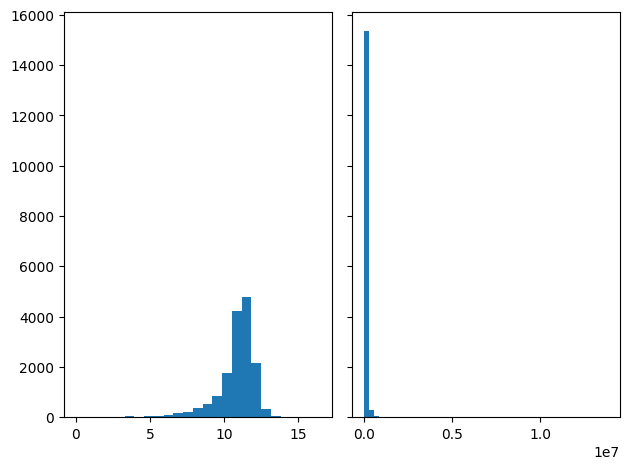

In [9]:
# make sure all columns have been converted to numeric
train_df = train_df.apply(pd.to_numeric)
# look at distribution of target
print(X_train.shape)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(train_df["LogConvertedCompYearly"], bins=25)
axs[1].hist(train_df["ConvertedCompYearly"], bins=50)
plt.show()

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],  # Trees from 100 to 1000
    'max_depth': [10, 20, 30, 50, None],                          # Maximum depth of trees
    'min_samples_split': [2, 5, 10],                              # Min samples to split
    'min_samples_leaf': [1, 2, 4],                                # Min samples per leaf
    'max_features': ['sqrt', 'log2', None],                       # Features to consider at splits
    'bootstrap': [True, False]                                    # Bootstrapping
}

# Instantiate the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                  # Number of parameter settings to sample
    cv=3,                       # Cross-validation folds
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1                   # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Collect results for each parameter set tried
results = random_search.cv_results_

# Print metrics for train, validation, and test sets
for i in range(len(results['params'])):
    params = results['params'][i]
    print(f"\nHyperparameters: {params}")
    
    # Train the model with the current parameters
    rf_model = RandomForestRegressor(**params, random_state=42)
    evaluate_rf(rf_model, X_train, X_val, X_test, y_train, y_val, y_test)


# Print the best parameters and the associated validation score
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Score (neg_MSE):", -random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits

Hyperparameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Train: R² = 0.7605, MSE = 0.4554, MAE = 0.3431
Validation: R² = 0.4317, MSE = 1.1137, MAE = 0.5893
Test: R² = 0.4122, MSE = 1.2673, MAE = 0.5969

Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Train: R² = 0.5305, MSE = 0.8926, MAE = 0.5686
Validation: R² = 0.3025, MSE = 1.3668, MAE = 0.7025
Test: R² = 0.2875, MSE = 1.5362, MAE = 0.7055

Hyperparameters: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Train: R² = 0.7359, MSE = 0.5021, MAE = 0.4059
Validation: R² = 0.3836, MSE = 1.2079, MAE = 0.6305
Test: R² = 0.3669, MSE = 1.3649, MAE = 0.6321

Hyperparameters: {'n_estimators': 300, 'min_samples_sp

In [11]:
# run best model with and without bagging

# create random forest regressors 
rf_baseline = RandomForestRegressor(n_estimators=500, min_samples_split=5, min_samples_leaf=1,
                                    max_features=None, max_depth=50, bootstrap=False)
rf_bootstrap = RandomForestRegressor(n_estimators=500, min_samples_split=5, min_samples_leaf=1,
                                    max_features=None, max_depth=50, bootstrap=True)

# fit and evaluate models
for rf_model, model_type in zip([rf_baseline, rf_bootstrap], ["baseline", "with boostrap"]):
    # Train the model with the current parameters
    print(f"running model {model_type}")
    rf_model.fit(X_train, y_train)
    evaluate_rf(rf_model, X_train, X_val, X_test, y_train, y_val, y_test)
    print("\n")

running model baseline
Train: R² = 0.9325, MSE = 0.1284, MAE = 0.1331
Validation: R² = -0.0307, MSE = 2.0198, MAE = 0.8377
Test: R² = 0.0908, MSE = 1.9603, MAE = 0.8124


running model with boostrap
Train: R² = 0.8813, MSE = 0.2257, MAE = 0.2525
Validation: R² = 0.4275, MSE = 1.1218, MAE = 0.5890
Test: R² = 0.4161, MSE = 1.2590, MAE = 0.5900




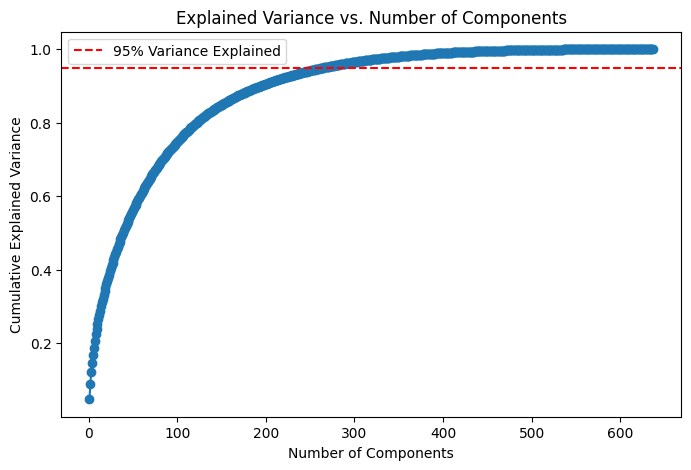

Number of components for 95% variance: 266


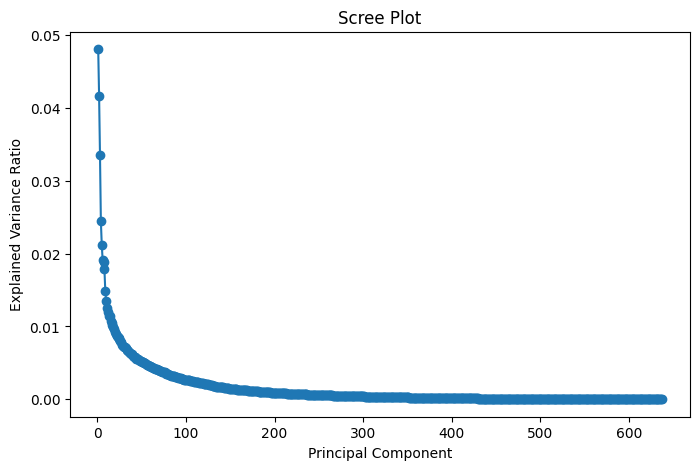

(15705, 637)


In [12]:
# Try PCA, first determine how many components to use
# Fit PCA to training data
pca = PCA()
pca.fit(X_train)

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.show()

# Print the number of components for 95% variance
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
print(f"Number of components for 95% variance: {n_components_95}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()
print(X_train.shape)

In [14]:
# Apply PCA
n_components = 266  # Choose number of components based on data (adjust as needed)
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)


# Fit Random Forest regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=2, max_leaf_nodes=None)
rf.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
evaluate_rf(rf_bootstrap, X_train_pca, X_val_pca, X_test_pca, y_train, y_val, y_test)

Train: R² = 0.8668, MSE = 0.2532, MAE = 0.3047
Validation: R² = 0.2049, MSE = 1.5580, MAE = 0.7883
Test: R² = 0.2020, MSE = 1.7207, MAE = 0.7886
